In [30]:
import pandas as pd
import numpy as np
from pathlib import Path
from stock_pull import*
import hvplot.pandas
from datetime import datetime

In [31]:
cleaned.tail(12)

,SPY Open,SPY Close,SPY Volume
date,,,
2000-07-20,149.0000,150.6250,4538900.0
2000-07-19,149.4687,148.5625,8506800.0
2000-07-18,150.6250,149.7656,4262100.0
2000-07-17,150.9843,151.0000,4208300.0
2000-07-14,150.4375,151.2500,5341900.0
2000-07-13,149.9843,149.7812,5356000.0
2000-07-12,149.2812,149.1250,5883000.0
2000-07-11,147.4687,148.1562,5431600.0
2000-07-10,147.8750,147.8437,2816100.0


## Run the Contrarian Strategy

In [32]:
def strategy(cleaned):
    #Create a new dataframe of only the closing values
    df = cleaned.loc[:,[i for i in cleaned.columns if i.endswith('Close')]]

    #Rename the columns as only the ticker (just drop the word 'close')
    df.columns = df.columns.str.replace(' Close','')
    
    # Sort the date by ascending order so that the pct change function calculates properly
    df = df.sort_index(ascending=True)

    #Loop through the columns and create a percentage change column
    for col in df.columns:
        ticker = col

        df[f"{ticker} % Change"] = df[col].pct_change() * 100

    
    
#     init an entry signal as 0.0 to use as it loops over the data 
    df['Entry'] = 0.0
    df['Entry'] = np.where(df['SPY % Change'] <= -1.0, 1.0, 0.0)
    df['Exit'] = 0.0
    df['Exit'] = np.where(df['SPY % Change'] >= 1.0, 1.0, 0.0)
    df['Signal'] = df['Entry'] - df['Exit']
    return df


def backtest(strat):
    backtest_df = strat[['SPY', 'SPY % Change', 'Entry', 'Exit', 'Signal']].copy()
    bt = backtest_df
    current_pos = 0
    cash = 100000
    bt['Current Position'] = current_pos
    bt['Current Cash'] = cash
    for i, row in bt.iterrows():

        if bt.at[i, 'Signal'] == 1 and current_pos == 0:
            current_pos += 100
            cash = cash - (bt.at[i, 'SPY']*current_pos)
            bt.at[i, 'Current Position'] = current_pos
            bt.at[i, 'Current Cash'] = cash

        elif bt.at[i, 'Signal'] == 1 and current_pos == 100:
            current_pos = current_pos
            cash = cash
            bt.at[i, 'Current Position'] = current_pos
            bt.at[i, 'Current Cash'] = cash

        elif bt.at[i, 'Signal'] == -1 and current_pos != 0:
            current_pos = 0
            cash = cash + (bt.at[i, 'SPY']*100)
            bt.at[i, 'Current Position'] = current_pos
            bt.at[i, 'Current Cash'] = cash

        elif bt.at[i, 'Signal'] == -1 and current_pos == 0:
            current_pos = current_pos
            cash = cash
            bt.at[i, 'Current Position'] = current_pos
            bt.at[i, 'Current Cash'] = cash

        elif bt.at[i, 'Signal'] == 0 and current_pos != 0:
            current_pos = current_pos
            cash = cash
            bt.at[i, 'Current Position'] = current_pos
            bt.at[i, 'Current Cash'] = cash
        elif bt.at[i, 'Signal'] == 0 and current_pos == 0:
            current_pos = 0
            cash = cash
            bt.at[i, 'Current Position'] = current_pos
            bt.at[i, 'Current Cash'] = cash

    return backtest_df

strat = strategy(cleaned)
bt = backtest(strat)
bt

,SPY,SPY % Change,Entry,Exit,Signal,Current Position,Current Cash
date,,,,,,,
2000-07-05,144.6250,NaN,0.0,0.0,0.0,0,100000
2000-07-06,145.7500,0.777874,0.0,0.0,0.0,0,100000
2000-07-07,148.0937,1.608027,0.0,1.0,-1.0,0,100000
2000-07-10,147.8437,-0.168812,0.0,0.0,0.0,0,100000
2000-07-11,148.1562,0.211372,0.0,0.0,0.0,0,100000
...,...,...,...,...,...,...,...
2020-06-30,308.3600,1.280956,0.0,1.0,-1.0,0,120275
2020-07-01,310.5700,0.716695,0.0,0.0,0.0,0,120275
2020-07-02,312.1900,0.521622,0.0,0.0,0.0,0,120275


In [77]:
# call in the bollinger signals from another notebook
bollinger_signal = pd.read_csv('./bollinger_band_signals.csv', index_col='date', infer_datetime_format=True)
bollinger_df = bollinger_signal['Signal']
# call in the SMA 215-225 signals from another notebook
sma_signal = pd.read_csv('./chris_all_signals.csv',index_col=0, infer_datetime_format=True)
sma_df = sma_signal['215-225 Signal']

signals_df = bt.join(bollinger_df, rsuffix=' B')
signals_df_final = signals_df.join(sma_df, rsuffix=' SMA')
signals_df_final

,SPY,SPY % Change,Entry,Exit,Signal,Current Position,Current Cash,Signal B,215-225 Signal
date,,,,,,,,,
2000-07-05,144.6250,NaN,0.0,0.0,0.0,0,100000,NaN,0.0
2000-07-06,145.7500,0.777874,0.0,0.0,0.0,0,100000,NaN,0.0
2000-07-07,148.0937,1.608027,0.0,1.0,-1.0,0,100000,NaN,0.0
2000-07-10,147.8437,-0.168812,0.0,0.0,0.0,0,100000,NaN,0.0
2000-07-11,148.1562,0.211372,0.0,0.0,0.0,0,100000,NaN,0.0
...,...,...,...,...,...,...,...,...,...
2020-06-30,308.3600,1.280956,0.0,1.0,-1.0,0,120275,NaN,1.0
2020-07-01,310.5700,0.716695,0.0,0.0,0.0,0,120275,NaN,1.0
2020-07-02,312.1900,0.521622,0.0,0.0,0.0,0,120275,NaN,1.0


In [79]:
signals_df_final.isnull().sum()

SPY                    0
SPY % Change           1
Entry                  0
Exit                   0
Signal                 0
Current Position       0
Current Cash           0
Signal B            4895
215-225 Signal         1
dtype: int64

In [84]:
signals_df_final['Signal B'].fillna(value=0, inplace=True)
signals_df_final['215-225 Signal'].fillna(value=0, inplace=True)
signals_df_final

,SPY,SPY % Change,Entry,Exit,Signal,Current Position,Current Cash,Signal B,215-225 Signal
date,,,,,,,,,
2000-07-05,144.6250,NaN,0.0,0.0,0.0,0,100000,0.0,0.0
2000-07-06,145.7500,0.777874,0.0,0.0,0.0,0,100000,0.0,0.0
2000-07-07,148.0937,1.608027,0.0,1.0,-1.0,0,100000,0.0,0.0
2000-07-10,147.8437,-0.168812,0.0,0.0,0.0,0,100000,0.0,0.0
2000-07-11,148.1562,0.211372,0.0,0.0,0.0,0,100000,0.0,0.0
...,...,...,...,...,...,...,...,...,...
2020-06-30,308.3600,1.280956,0.0,1.0,-1.0,0,120275,0.0,1.0
2020-07-01,310.5700,0.716695,0.0,0.0,0.0,0,120275,0.0,1.0
2020-07-02,312.1900,0.521622,0.0,0.0,0.0,0,120275,0.0,1.0


In [85]:
signals_df_final.isnull().sum()

SPY                 0
SPY % Change        1
Entry               0
Exit                0
Signal              0
Current Position    0
Current Cash        0
Signal B            0
215-225 Signal      0
dtype: int64

In [89]:
x_var_list = ['Signal', 'Signal B', '215-225 Signal']
signals_df_final[x_var_list].tail()

,Signal,Signal B,215-225 Signal
date,,,
2020-06-30,-1.0,0.0,1.0
2020-07-01,0.0,0.0,1.0
2020-07-02,0.0,0.0,1.0
2020-07-06,-1.0,0.0,1.0
2020-07-07,1.0,0.0,0.0


## Construct the Dependent Variable

In [90]:
bt['Positive Return'] = np.where(bt['SPY % Change'] > 0, 1.0, 0.0)
bt.tail(20)

,SPY,SPY % Change,Entry,Exit,Signal,Current Position,Current Cash,Positive Return
date,,,,,,,,
2020-06-09,320.79,-0.745668,0.0,0.0,0.0,0,119603,0.0
2020-06-10,319.00,-0.557997,0.0,0.0,0.0,0,119603,0.0
2020-06-11,300.61,-5.764890,1.0,0.0,1.0,100,89542,0.0
2020-06-12,304.21,1.197565,0.0,1.0,-1.0,0,119963,1.0
2020-06-15,307.05,0.933566,0.0,0.0,0.0,0,119963,1.0
2020-06-16,312.96,1.924768,0.0,1.0,-1.0,0,119963,1.0
2020-06-17,311.66,-0.415389,0.0,0.0,0.0,0,119963,0.0
2020-06-18,311.78,0.038503,0.0,0.0,0.0,0,119963,1.0
2020-06-19,308.64,-1.007120,1.0,0.0,1.0,100,89099,0.0


In [91]:
training_start = bt.index.min()
training_end = '2016-09-14'

testing_start =  '2016-09-15'
testing_end = bt.index.max()

print(f"Training Start: {training_start}")
print(f"Training End: {training_end}")
print(f"Testing Start: {testing_start}")
print(f"Testing End: {testing_end}")

Training Start: 2000-07-05 00:00:00
Training End: 2016-09-14
Testing Start: 2016-09-15
Testing End: 2020-07-07 00:00:00


In [92]:
X_train = signals_df_final[x_var_list][training_start:training_end]
y_train = bt['Positive Return'][training_start:training_end]

X_train.tail()

,Signal,Signal B,215-225 Signal
date,,,
2016-09-08,0.0,-1.0,1.0
2016-09-09,1.0,0.0,1.0
2016-09-12,-1.0,0.0,1.0
2016-09-13,1.0,0.0,0.0
2016-09-14,0.0,1.0,0.0


In [93]:
y_train.tail()

date
2016-09-08    0.0
2016-09-09    0.0
2016-09-12    1.0
2016-09-13    0.0
2016-09-14    0.0
Name: Positive Return, dtype: float64

In [94]:
X_test = signals_df_final[x_var_list][testing_start:testing_end]
y_test = bt['Positive Return'][testing_start:testing_end]

X_test.tail()

,Signal,Signal B,215-225 Signal
date,,,
2020-06-30,-1.0,0.0,1.0
2020-07-01,0.0,0.0,1.0
2020-07-02,0.0,0.0,1.0
2020-07-06,-1.0,0.0,1.0
2020-07-07,1.0,0.0,0.0


In [95]:
y_test.tail()

date
2020-06-30    1.0
2020-07-01    1.0
2020-07-02    1.0
2020-07-06    1.0
2020-07-07    0.0
Name: Positive Return, dtype: float64

In [96]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification

In [97]:
model = RandomForestClassifier(n_estimators=100, max_depth=3, random_state=0)
model.fit(X_train, y_train)

predictions = model.predict(X_test)

Results = y_test.to_frame()
Results["Predicted Value"] = predictions
Results['Return'] = bt['SPY % Change']
Results.head()

,Positive Return,Predicted Value,Return
date,,,
2016-09-15,1.0,1.0,0.999296
2016-09-16,0.0,1.0,-0.887217
2016-09-19,1.0,1.0,0.018747
2016-09-20,1.0,1.0,0.004686
2016-09-21,1.0,1.0,1.124543


In [98]:
%matplotlib inline

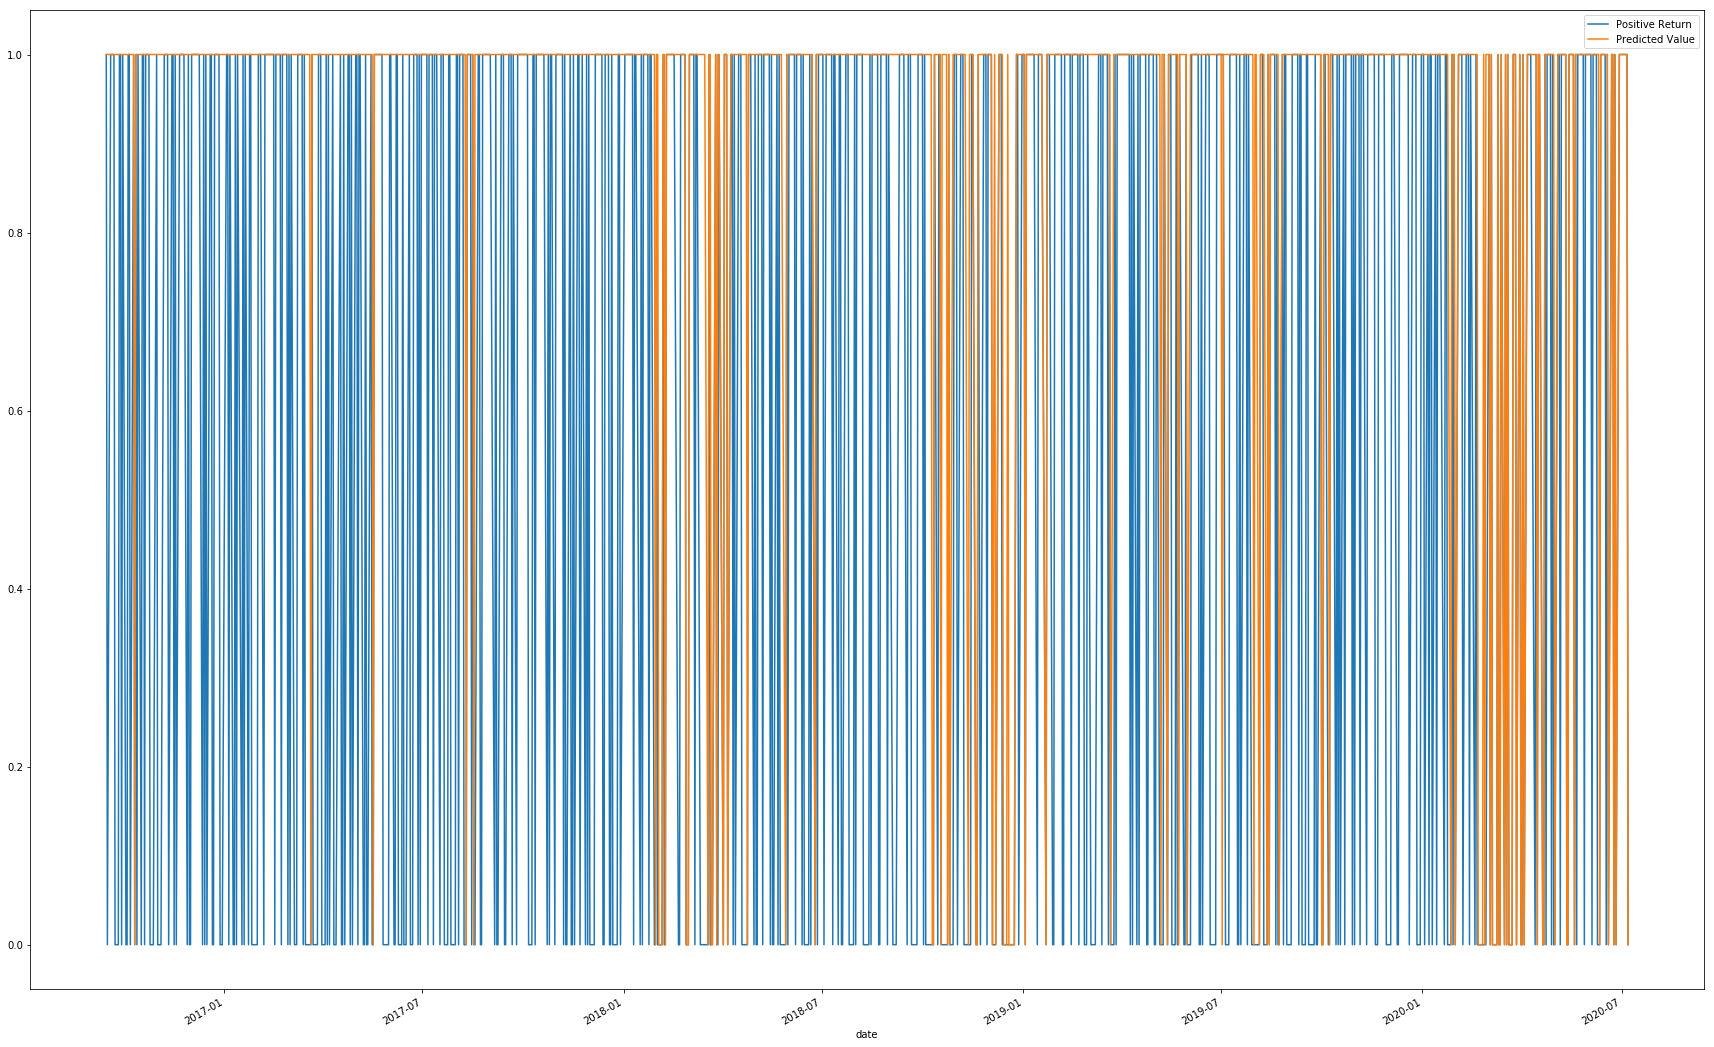

In [99]:
Results[['Positive Return', 'Predicted Value']].plot(figsize=(30,20))

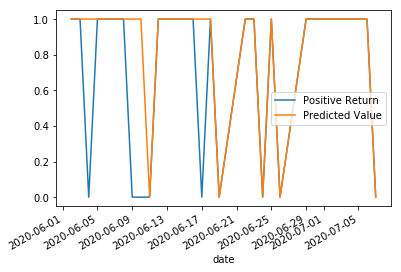

In [100]:
Results[['Positive Return', 'Predicted Value']].tail(25).plot()

In [109]:
Results['Predicted Value'].replace(0, -1, inplace=True)
Results.tail(50)

,Positive Return,Predicted Value,Return
date,,,
2020-04-27,1.0,1.0,1.441849
2020-04-28,0.0,1.0,-0.459850
2020-04-29,1.0,1.0,2.617856
2020-04-30,0.0,1.0,-0.931073
2020-05-01,0.0,-1.0,-2.647342
2020-05-04,1.0,1.0,0.275823
2020-05-05,1.0,1.0,0.923934
2020-05-06,0.0,1.0,-0.677871
2020-05-07,1.0,1.0,1.206684


In [115]:
(1 + (Results['Return'] * Results['Predicted Value'])).hvplot.scatter()

:Scatter   [date]   (0)

In [116]:
initial_capital = 100000

# Plot cumulative return of model in terms of capital
cumulative_return_capital = initial_capital * (1 + (Results['Return'] * Results['Predicted Value']))
crc_plot = cumulative_return_capital.hvplot.line()
crc_plot.opts(yformatter='%.0f')

:Curve   [date]   (0)

In [118]:
from numpy.random import seed

seed(1)

from tensorflow import random

random.set_seed(2)

ModuleNotFoundError: No module named 'tensorflow'

In [ ]:
def window_data(signals_df_final, window, feature_col_number, target_col_number):
    
    X = []
    y = []
    for i in range(len(signals_df_final) - window - 1):
        features = signals_df_final.iloc[i : (i + window), feature_col_number]
        target = signals_df_final.iloc[(i + window), target_col_number]
        X.append(features)
        y.append(target)
    return np.array(X), np.array(y).reshape(-1, 1)